In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/emotion_dataset.csv')

#Function for Text Augmentation with synonym replacement
def augment(text):
    augmented_text = []
    for word in text:
        synsets = wordnet.synsets(word)
        if synsets:
            synonyms = synsets[0].lemma_names()[:2]  # Considering only the two synonym for simplicity
            if synonyms:
                augmented_text.append(synonyms[0])
            else:
                augmented_text.append(word)
        else:
            augmented_text.append(word)

    return ' '.join(augmented_text)

# Augment dataset
augmented_data = []
for idx, row in data.iterrows():
    text = row['text']
    emotion = row['emotion']

    augmented_data.append((text, emotion))  # Original data
    augmented_data.append((augment(text), emotion))  # Augument data

# Convert to DataFrame
augmented_df = pd.DataFrame(augmented_data, columns=['text', 'emotion'])

# Combine original and augmented data
combined_data = pd.concat([data, augmented_df], ignore_index=True)

# Initialize WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Text Preprocessing
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters except spaces
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatize the tokens
    return tokens

# Apply text preprocessing
combined_data['text'] = combined_data['text'].apply(preprocess_text)

# Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(combined_data['text'])
sequences = tokenizer.texts_to_sequences(combined_data['text'])
padded_sequences = pad_sequences(sequences, maxlen=100)

# Load pre-trained word embeddings (GloVe)
embeddings_dictionary = {}
with open('/content/drive/MyDrive/glove.6B.100d.txt', encoding="utf8") as glove_file:
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

# Create embedding matrix using GloVe word embeddings
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# One-hot encoding of the 'emotion' column
encoder = OneHotEncoder()
encoded_emotion = encoder.fit_transform(combined_data['emotion'].values.reshape(-1, 1)).toarray()

# Apply Oversampling to balance classes
oversample = RandomOverSampler(random_state=42)
x_resampled, y_resampled = oversample.fit_resample(padded_sequences, encoded_emotion)

# Splitting the oversampled dataset into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

# Define BiLSTM Model
def bilstm_model(vocab_size, embedding_matrix):
    input_text = Input(shape=(100,))
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=100, trainable=True)(input_text)

    # Bidirectional LSTM layers
    bilstm = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
    bilstm = Dropout(0.5)(bilstm)
    bilstm = Bidirectional(LSTM(128, return_sequences=True))(bilstm)
    bilstm = Dropout(0.5)(bilstm)

    # Additional layers for fine-tuning
    bilstm = Bidirectional(LSTM(64))(bilstm)
    bilstm = Dropout(0.5)(bilstm)

    output = Dense(8, activation='softmax')(bilstm)

    model = Model(inputs=input_text, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()
    return model

# Create the model
model = bilstm_model(vocab_size, embedding_matrix)

# Early stopping based on validation loss
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, epochs=15, batch_size=128, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {accuracy}')

# Make predictions
predictions = model.predict(x_test)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          3713100   
                                                                 
 bidirectional (Bidirection  (None, 100, 256)          234496    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 100, 256)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 100, 256)          394240    
 onal)                                                          

In [2]:
# Evaluate the model
scores = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Loss: {scores[0]* 100:.2f}%")
print(f"Test Accuracy: {scores[1]* 100:.2f}%")

Test Loss: 30.13%
Test Accuracy: 91.72%


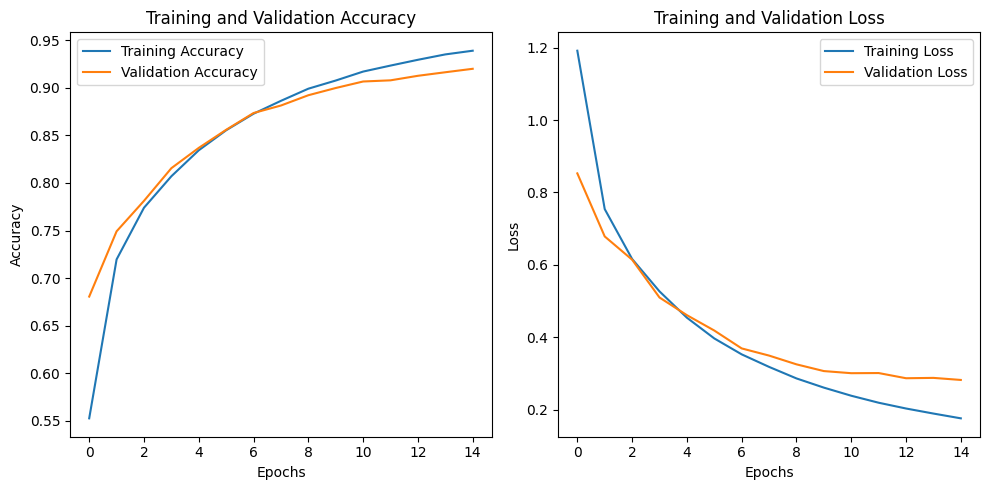

In [3]:
import matplotlib.pyplot as plt
# Retrieve training history for metrics
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plotting training and validation accuracy over epochs
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [4]:
from sklearn.metrics import fbeta_score

# Make predictions on test data
y_pred = model.predict(x_test)

y_test_int = y_test.argmax(axis=1)

beta_values = [0.5, 1, 2]
# Calculate F-beta score
for beta in beta_values:
    score = fbeta_score(y_test_int, y_pred.argmax(axis=1), average='weighted', beta=beta)
    score_percentage = score * 100  # Convert to percentage
    print(f"F-beta Score (beta={beta}): {score_percentage:.2f}%")

1657/1657 [==============================] - 19s 11ms/step
F-beta Score (beta=0.5): 91.61%
F-beta Score (beta=1): 91.61%
F-beta Score (beta=2): 91.66%


1657/1657 [==============================] - 18s 11ms/step
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6598
           1       0.99      0.99      0.99      6623
           2       0.90      0.92      0.91      6636
           3       0.87      0.75      0.80      6578
           4       0.96      0.99      0.98      6602
           5       0.85      0.83      0.84      6568
           6       1.00      1.00      1.00      6766
           7       0.89      0.92      0.90      6645

    accuracy                           0.92     53016
   macro avg       0.92      0.92      0.92     53016
weighted avg       0.92      0.92      0.92     53016



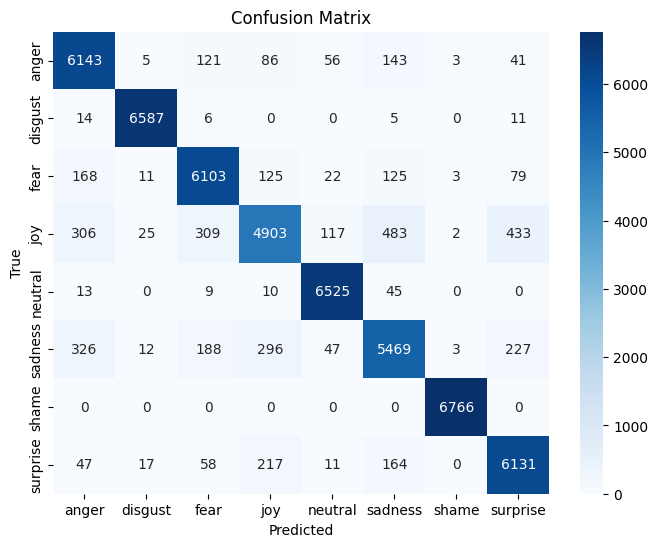

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
# Perform emotion prediction on test set
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_test_labels, y_pred_labels))

import seaborn as sns

# Error Analysis: Confusion Matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
# Sample input text for prediction
input_text = "Today weather is glommy and dull, it's making me feel a bit down. "

# Preprocess the input text
preprocessed_input = preprocess_text(input_text)

# Tokenize and pad the preprocessed input text
input_sequence = tokenizer.texts_to_sequences([preprocessed_input])
padded_input_sequence = pad_sequences(input_sequence, maxlen=100)

# Make prediction using the trained model
predicted_probabilities = model.predict(padded_input_sequence)

# Get the predicted emotion label (assuming 'encoder' is the OneHotEncoder used in training)
predicted_label = encoder.inverse_transform(predicted_probabilities)[0]

print(f"Predicted Emotion: {predicted_label}")


1/1 [==============================] - 0s 39ms/step
Predicted Emotion: ['joy']


In [16]:
# # Save the model
# model.save('emotion_detection_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# import pickle

# # Save tokenizer
# with open('tokenizer.pkl', 'wb') as tokenizer_file:
#     pickle.dump(tokenizer, tokenizer_file)

# # Save encoder
# with open('encoder.pkl', 'wb') as encoder_file:
#     pickle.dump(encoder, encoder_file)


In [10]:
from sklearn.metrics import classification_report

# Make predictions
predictions = model.predict(x_test)

# Convert predictions and true labels back to original classes
y_pred_classes = np.argmax(predictions, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Get class labels from the encoder
emotion_labels = encoder.categories_[0]

# Generate classification report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=emotion_labels)
print("Classification Report:\n", class_report)

1657/1657 [==============================] - 18s 11ms/step
Classification Report:
               precision    recall  f1-score   support

       anger       0.88      0.93      0.90      6598
     disgust       0.99      0.99      0.99      6623
        fear       0.90      0.92      0.91      6636
         joy       0.87      0.75      0.80      6578
     neutral       0.96      0.99      0.98      6602
     sadness       0.85      0.83      0.84      6568
       shame       1.00      1.00      1.00      6766
    surprise       0.89      0.92      0.90      6645

    accuracy                           0.92     53016
   macro avg       0.92      0.92      0.92     53016
weighted avg       0.92      0.92      0.92     53016



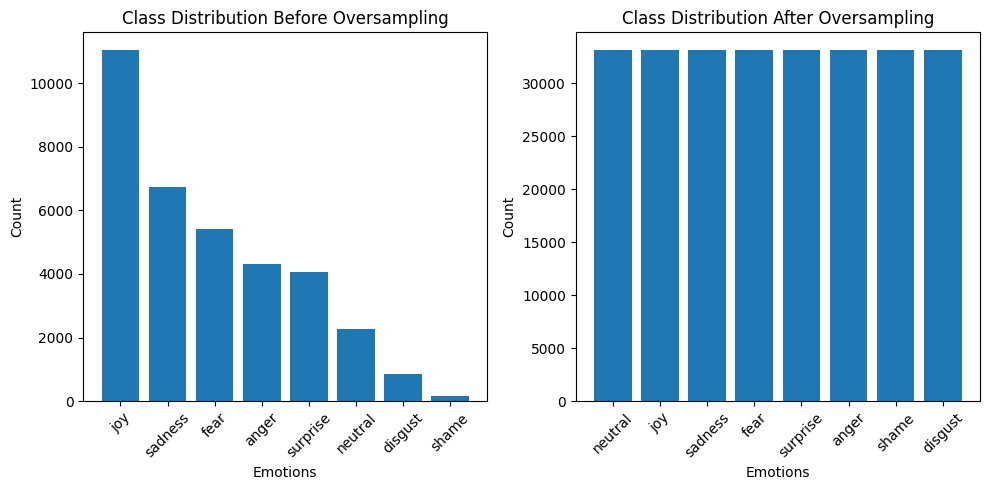

In [11]:
import matplotlib.pyplot as plt

# Count occurrences of each class before and after oversampling
classes_before_oversampling = data['emotion'].value_counts()
classes_after_oversampling = pd.DataFrame(y_resampled, columns=data['emotion'].unique()).sum()

# Plot class distribution before and after oversampling
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(classes_before_oversampling.index, classes_before_oversampling.values)
plt.title('Class Distribution Before Oversampling')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.bar(classes_after_oversampling.index, classes_after_oversampling.values)
plt.title('Class Distribution After Oversampling')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


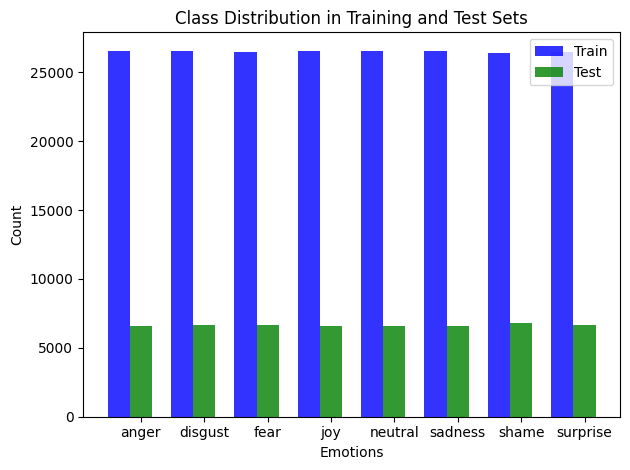

In [12]:
import matplotlib.pyplot as plt

# Calculate class distribution in the training set
train_class_distribution = np.sum(y_train, axis=0)

# Calculate class distribution in the test set
test_class_distribution = np.sum(y_test, axis=0)

# Get the encoded emotion labels
encoded_emotion_labels = encoder.categories_[0]  # Assuming encoder is the OneHotEncoder used to encode emotions

# Plot the class distribution
fig, ax = plt.subplots()
index = np.arange(len(encoded_emotion_labels))
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, train_class_distribution, bar_width,
alpha=opacity,
color='b',
label='Train')

rects2 = plt.bar(index + bar_width, test_class_distribution, bar_width,
alpha=opacity,
color='g',
label='Test')

plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Class Distribution in Training and Test Sets')
plt.xticks(index + bar_width, encoded_emotion_labels)
plt.legend()

plt.tight_layout()
plt.show()


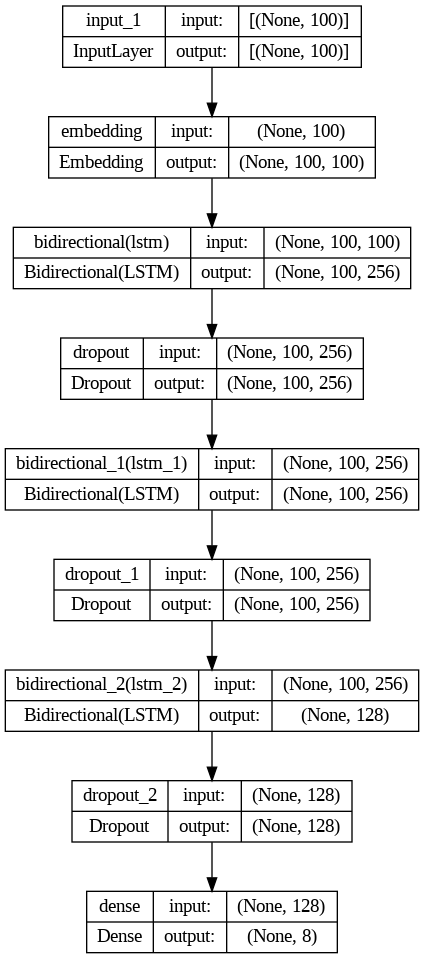

In [13]:
from tensorflow.keras.utils import plot_model
# Plot the model architecture
plot_model(model, to_file='bilstm_model_plot.png', show_shapes=True, show_layer_names=True)